# Assignment 4 : Structured Illumination and Meshing

---
Please edit the cell below to include your name and student ID #

**name:**Mauricio Lomeli

**SID:**23329506

In [26]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from camutils import Camera,triangulate
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
plt.rcParams['figure.figsize'] = [10,10]
# opencv for 3v virtual rotation

***

# 1. Decoding

Write a function called **decode** that reads in a set of images captured with the camera showing the projected gray code and returns an array which is the same size as the camera image where each element contains the decoded value (0..1023) as well as a binary image (mask) indicating which pixels could be reliably decoded. We will end up calling this function 4 times, once for the horizontal and once for the vertical coordinates in both the left and right cameras. 


## 1.1 Implement [25pts]

Use a for loop to generate the list of image file names to load in. Assume that there are 20 images for the 10 bit gray code.  The images come in pairs where the second is the inverse of the first.  For each pair of images, recover the bit by checking to see that the first image is greater or less than the second.  You should also maintain a seperate binary array (mask) the same size as the images in which you mark "undecodable" pixels for which the absolute difference between the first and second image in the pair is smaller than some user defined threshold.  This will allow us to ignore pixels for which the decoding is likely to fail (e.g., pixels that weren't illuminated by the projector). I used a threshold of 0.02 when reconstructing the scan below. You will want to mark a pixel as bad if any of the 10 bits was undecodeable.

After thresholding the pairs you should have 10 binary images.  You can convert this stack of binary images
into a single "decimal image" by decoding each bit pattern to its corresponding decimal representation.  As
discussed in class, the bits are coded using a graycode rather than a standard binary code so you will need to
do a little work to decode them correctly.

I recommend first converting the 10 bit code from the gray code to standard binary (binary coded decimal) using the algorithm we described in class that successively XORs the bits. Once you have converted to BCD, you can then produce the final decimal value using the standard binary-to-decimal conversion  (i.e., $\sum_{n=0}^9 B[9-n]*2^n$). 

In NumPy you can implement both steps efficiently with a for-loop over the 10 bits and vectorized operations
over the spatial locations. Make sure you are processing the bits in the correct order (i.e. from least-significant to most-significant).


In [27]:

def decode(imprefix, start, threshold):
    """
    Decode 10bit gray code pattern with the given difference
    threshold.  We assume the images come in consective pairs
    with filenames of the form <prefix><start>.png - <prefix><start+20>.png
    (e.g. a start offset of 20 would yield image20.png, image01.png... image39.png)

    Parameters
    ----------
    imprefix : str
      prefix of where to find the images (assumed to be .png)

    start : int
      image offset.

    threshold : float

    Returns
    -------
    code : 2D numpy.array (dtype=float)

    mask : 2D numpy.array (dtype=float)


    """
    nbits = 10

    imgs = list()
    imgs_inv = list()
    print('loading', end='')
    for i in range(start, start + 2 * nbits, 2):
        fname0 = '%s%2.2d.png' % (imprefix, i)
        fname1 = '%s%2.2d.png' % (imprefix, i + 1)
        print('(', i, i + 1, ')', end='')
        img = plt.imread(fname0)
        img_inv = plt.imread(fname1)
        if (img.dtype == np.uint8):
            img = img.astype(float) / 256
            img_inv = img_inv.astype(float) / 256
        if (len(img.shape) > 2):
            img = np.mean(img, axis=2)
            img_inv = np.mean(img_inv, axis=2)
        imgs.append(img)
        imgs_inv.append(img_inv)

    (h, w) = imgs[0].shape
    print('\n')

    gcd = np.zeros((h, w, nbits))
    mask = np.ones((h, w))
    for i in range(nbits):
        gcd[:, :, i] = imgs[i] > imgs_inv[i]
        mask = mask * (np.abs(imgs[i] - imgs_inv[i]) > threshold)

    bcd = np.zeros((h, w, nbits))
    bcd[:, :, 0] = gcd[:, :, 0]
    for i in range(1, nbits):
        bcd[:, :, i] = np.logical_xor(bcd[:, :, i - 1], gcd[:, :, i])

    code = np.zeros((h, w))
    for i in range(nbits):
        code = code + np.power(2, (nbits - i - 1)) * bcd[:, :, i]

    return code, mask

***

## 1.2 Test and Visualize [5pts]

The graycode images which are projected are included in the data sub-directory **gray/**.  This is useful for
debugging your decode function prior to running it on the real scan data since the results should be perfect
(no noise!).  

1. Check that your decode function correct decodes the projector data
2. Visualize the results of running your decode function on one of the provided scans


loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )



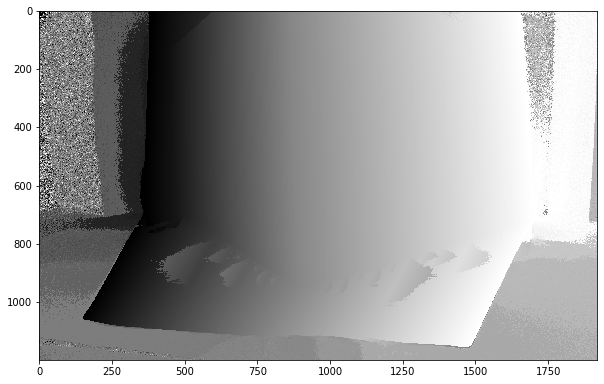

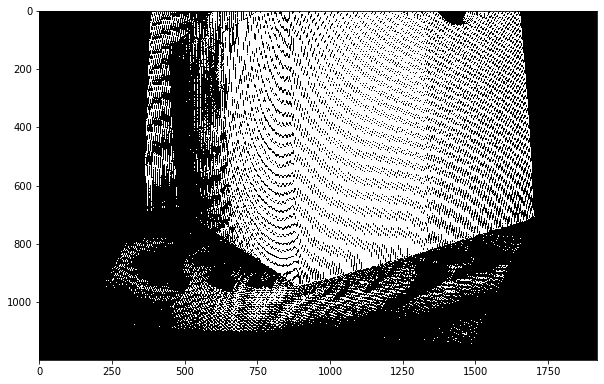

In [28]:
#
# first generate arrays containing the "true" codes projected by 
# the projector
#
# the projector had a resolution of 1280x800 so there are black bars 
# of 128 pixels on either side of our 1024 pixel region

pad = np.zeros((800,128))
hcode,vcode = np.meshgrid(range(1024),range(800))
Htrue = np.concatenate((pad,hcode,pad),axis=1) # 129 - 1151 = increasing by 1's starting @ 129: 1 -> 1151: 1023
Vtrue = np.concatenate((pad,vcode,pad),axis=1) # all = 0's
masktrue = np.concatenate((pad,np.ones((800,1024)),pad),axis=1) # 128 - 999 = 1's

#
# run your decoding on the projector images
#
path = r'C:/Users/mrtma/OneDrive/School/Project in Computer Vision/Notebook/Assignment4/Structured-Illumination-Meshing'
thresh = 0.0000001  #this data is perfect so we can use a very small threshold
H,Hmask = decode(path+'/gray/',0,thresh)
V,Vmask = decode(path+'/gray/',20,thresh)

# compare to the known "true" code
assert((H==Htrue).all())
assert((V==Vtrue).all())
assert((Hmask==masktrue).all())
assert((Vmask==masktrue).all())


#
# Visualize results for the first scan and experiment to determine a good threshold
#
thresh = 0.05 # NEED TO FIND A GOOD NUMBER TO EXPERIMENT WITH THE THRESHOLD
code,mask = decode(path + '/scan0/frame_C0_',0,thresh)

# diusplay view code and mask as images
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(code, cmap=plt.cm.gray)
plt.show()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mask, cmap=plt.cm.gray)
plt.show()

***
# 2. Reconstruction 

We can now use the decoded pixel ids in order to easily find correspondences between two different camera views and triangulate the resulting points. You can use your own implementation from assignment 2 or import the provided **camutils.py** module as needed to do the triangulation. 

## 2.1 Implementation [25pts]

Write a function called **reconstruct** that takes a set of graycoded images from the pair of cameras and produces a 3D point cloud.  To achieve this:

1. Call your decode function four times to decode the horizontal and vertical images for both the left and right cameras. If you visualize the resulting codes, they should look like the figure below.  You should combine the horizontal and vertical codes to get a single (20-bit) integer for the left and right cameras.  You should also combine the corresponding binary masks so only pixels with both good horizontal and vertical codes are marked as valid.

2. For each pixel in the left image which was succesfully decoded, find the pixel in the right image with the corresponding code. One way to do this effeciently is using the **numpy.intersect1d** function with *return_indices=True* in order to get indices of matching pixels in the two images.

3. Now that you have corrsponding pixel coordinates in the two images and the camera parameters, use **triangulate** to get the 3D coordinates for this set of pixels. 

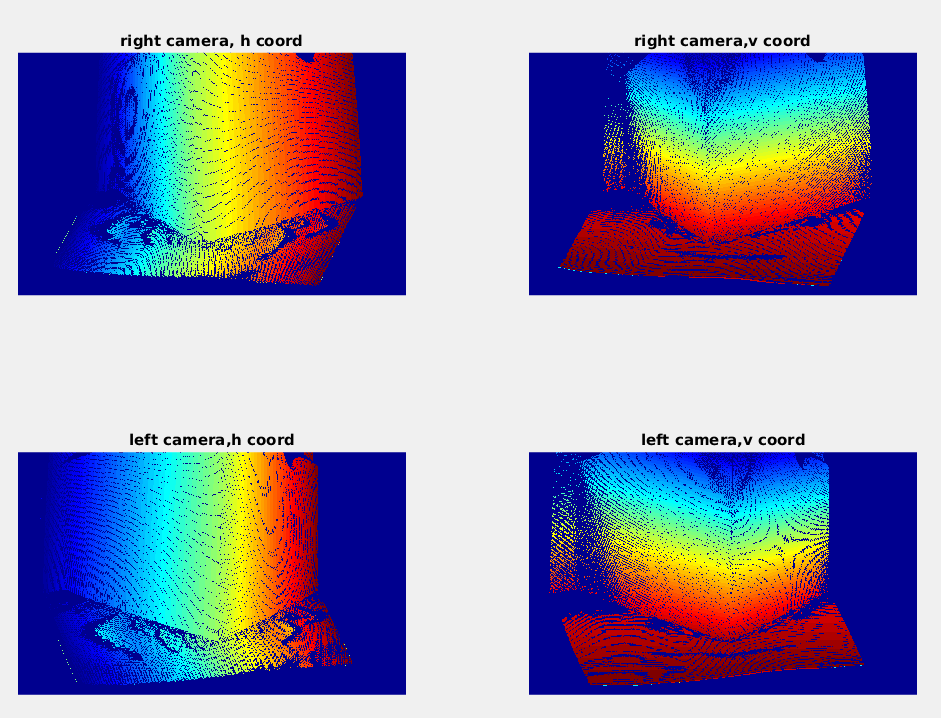

In [29]:
def reconstruct(imprefixL, imprefixR, threshold, camL, camR):
    """
    Simple reconstruction based on triangulating matched pairs of points
    between to view which have been encoded with a 20bit gray code.

    Parameters
    ----------
    imprefix : str
      prefix for where the images are stored

    threshold : float
      decodability threshold

    camL,camR : Camera
      camera parameters

    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)

    pts3 : 2D numpy.array (dtype=float)

    """

    CLh, maskLh = decode(imprefixL, 0, threshold)
    CLv, maskLv = decode(imprefixL, 20, threshold)
    CRh, maskRh = decode(imprefixR, 0, threshold)
    CRv, maskRv = decode(imprefixR, 20, threshold)

    CL = CLh + 1024 * CLv
    maskL = maskLh * maskLv
    CR = CRh + 1024 * CRv
    maskR = maskRh * maskRv

    h = CR.shape[0]
    w = CR.shape[1]

    subR = np.nonzero(maskR.flatten())
    subL = np.nonzero(maskL.flatten())

    CRgood = CR.flatten()[subR]
    CLgood = CL.flatten()[subL]

    _, submatchR, submatchL = np.intersect1d(CRgood, CLgood, return_indices=True)

    matchR = subR[0][submatchR]
    matchL = subL[0][submatchL]

    xx, yy = np.meshgrid(range(w), range(h))
    xx = np.reshape(xx, (-1, 1))
    yy = np.reshape(yy, (-1, 1))

    pts2R = np.concatenate((xx[matchR].T, yy[matchR].T), axis=0)
    pts2L = np.concatenate((xx[matchL].T, yy[matchL].T), axis=0)

    pts3 = triangulate(pts2L, camL, pts2R, camR)

    return pts2L, pts2R, pts3



***

## 2.2 Visualization [5pts]

I've have provided the calibration for the two cameras in the scan0/scan0_calibration.pickle so that you can easily load them in to your code.  Call your **reconstruct** function on the provided image data and visualize the reconstructed 3D points to make sure everything is working. You may want to experiment with adjusting the decoding threshold to get a good number of points without too much noise. 

Please note that at this stage the results are quite noisy so if you plot them, you will probably need to zoom in to see the main object. You can adjust your plot axes to set the extent of the plot axis after displaying the points.  For this scan, axis limits of [-200 400],[-200 300], and [-200 200] in the x,y and z directions repectively should work well.

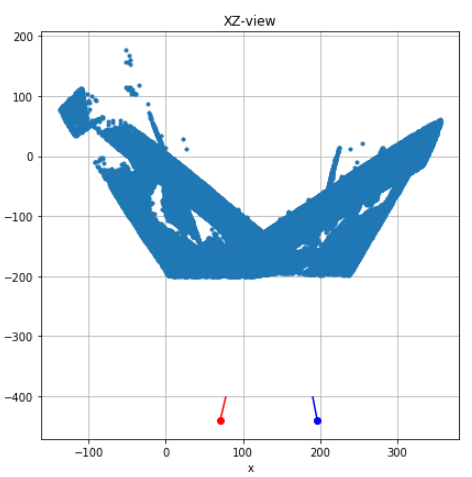

Camera : 
 f=1412 
 c=[[995 582]] 
 R=[[ 0.9885 -0.0185 -0.1504]
 [-0.0018  0.991  -0.1336]
 [ 0.1515  0.1324  0.9796]] 
 t = [[ 196.4  144.5 -440.6]]
Camera : 
 f=1410 
 c=[[986 608]] 
 R=[[ 0.9834 -0.024   0.1797]
 [ 0.0454  0.9922 -0.1157]
 [-0.1756  0.122   0.9769]] 
 t = [[  70.5  148.1 -440.6]]
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



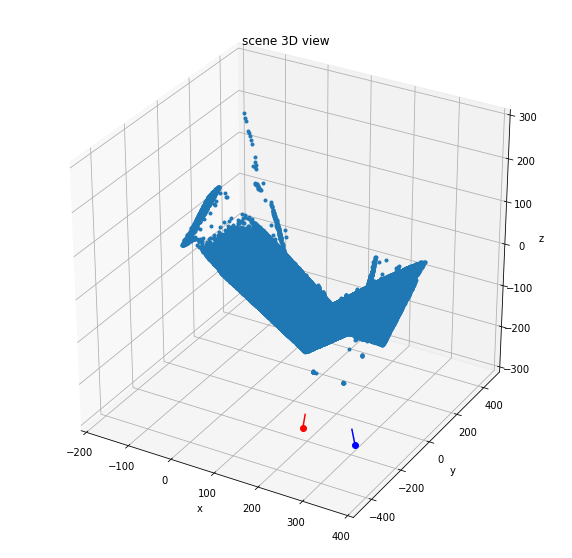

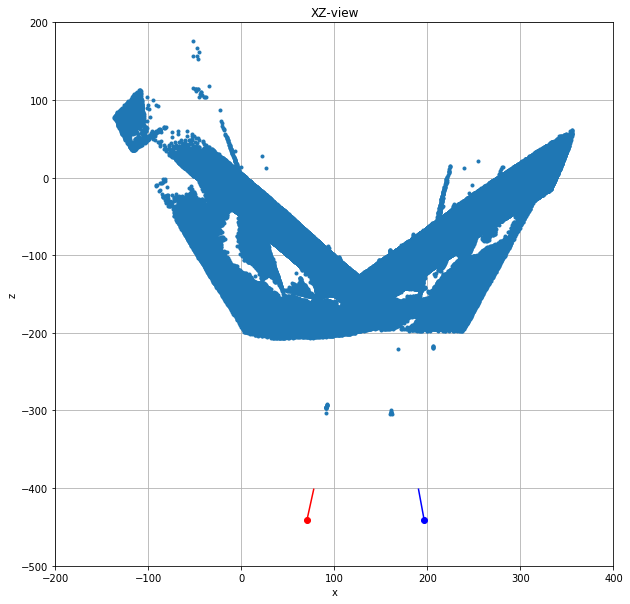

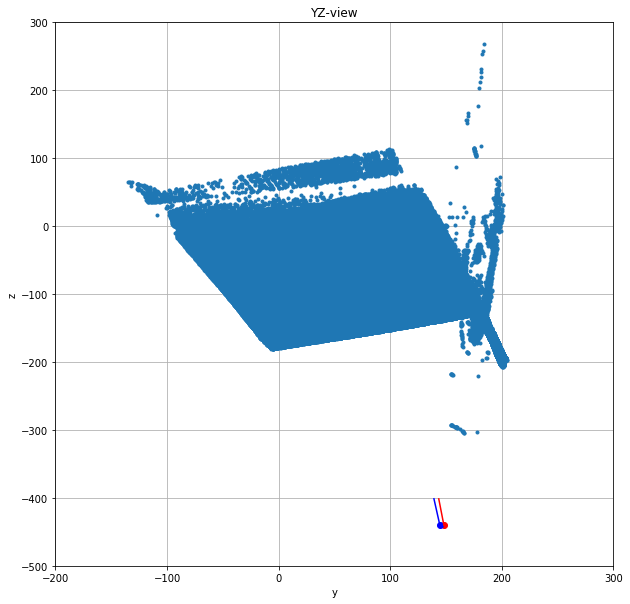

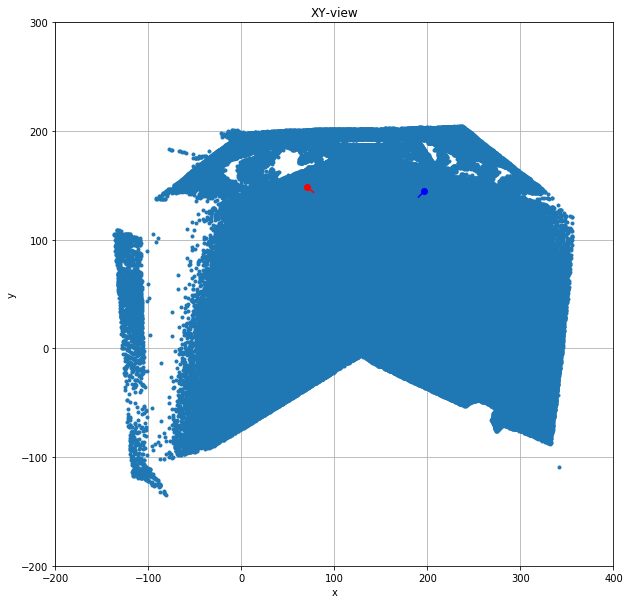

In [30]:
#
# Reconstruct and visualize the results
#
imprefixC0 = r'C:/Users/mrtma/OneDrive/School/Project in Computer Vision/Notebook/Assignment4/Structured-Illumination-Meshing/scan0/frame_C0_'
imprefixC1 = r'C:/Users/mrtma/OneDrive/School/Project in Computer Vision/Notebook/Assignment4/Structured-Illumination-Meshing/scan0/frame_C1_'
threshold = 0.02

fid = open('scan0/scan0_calibration.pickle', 'rb')
(camL, camR) = pickle.load(fid)
fid.close

print(camL)
print(camR)
pts2L, pts2R, pts3 = reconstruct(imprefixC0, imprefixC1, threshold, camL, camR)

# Add your visualization code here.  As we have done previously it is good to visualize different
# 2D projections XY, XZ, YZ and well as a 3D version

# visualize the left and right image overlaid
lookL = np.hstack((camL.t, camL.t + camL.R @ np.array([[0, 0, 40]]).T))
lookR = np.hstack((camR.t, camR.t + camR.R @ np.array([[0, 0, 40]]).T))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(pts3[0, :], pts3[1, :], pts3[2, :], '.')
ax.plot(camR.t[0], camR.t[1], camR.t[2], 'ro')
ax.plot(camL.t[0], camL.t[1], camL.t[2], 'bo')
ax.plot(lookL[0, :], lookL[1, :], lookL[2, :], 'b')
ax.plot(lookR[0, :], lookR[1, :], lookR[2, :], 'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')
ax.set_zlim(-300, 300)
ax.set_ylim(-500, 500)
ax.set_xlim(-200, 400)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-200, 400)
ax.set_ylim(-500, 200)
ax.plot(pts3[0, :], pts3[2, :], '.')
ax.plot(camR.t[0], camR.t[2], 'ro')
ax.plot(camL.t[0], camL.t[2], 'bo')
ax.plot(lookL[0, :], lookL[2, :], 'b')
ax.plot(lookR[0, :], lookR[2, :], 'r')
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-200, 300)
ax.set_ylim(-500, 300)
ax.plot(pts3[1, :], pts3[2, :], '.')
ax.plot(camR.t[1], camR.t[2], 'ro')
ax.plot(camL.t[1], camL.t[2], 'bo')
ax.plot(lookL[1, :], lookL[2, :], 'b')
ax.plot(lookR[1, :], lookR[2, :], 'r')
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-200, 400)
ax.set_ylim(-200, 300)
ax.plot(pts3[0, :], pts3[1, :], '.')
ax.plot(camR.t[0], camR.t[1], 'ro')
ax.plot(camL.t[0], camL.t[1], 'bo')
ax.plot(lookL[0, :], lookL[1, :], 'b')
ax.plot(lookR[0, :], lookR[1, :], 'r')
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

***

# 3. Meshing

To display the reconstructed scan as a surface, we need to generate triangular faces of the mesh which connect up the points. Write code that takes the output of **reconstruct** and produces a triangulated mesh. Your mesh should be represented by an array of points (vertices) and an array of triplets of point indices (triangular faces).


## 3.1 Implementation [35pts]

**reconstruct** provides us with the set of verticies.  To find the faces of your mesh, we will use the 2D
coordinates of the points as they were visible in the left image (**pts2L**).  Use the function **scipy.spatial.Delaunay** on these 2D coordinates to get the list of triangles.  These faces along with the 3D coordinates of the points provide a description of the surface in 3D.  You can display the resulting surface mesh in using **plot_trisurf** passing it the coordinates in **pts3** and the triangles in **tri** returned by Delaunay that contains the list of triangles.

You will also need to implement some code in your mesh function for pruning out noisy points.  Please
implement the following two ideas:

**(a) Bounding Box Pruning:** The scanned object lies in a bounding box roughly 400mm on a side.  Prune the set of triangulated points to only keep those that are inside this 3D volume.  You will need to experiment to find the best bounding box dimensions along the x,y and z coordinates in order to enclose the surface but exclude as much of the noise points as possible.  Once you have determined a good range, you should drop points in *pts3* that are outside that range.  You should also drop the corresponding 2D points stored in *pts2L* and *pts2R*.  Once you have dropped the points outside the bounding box, you should (re)run **Delaunay** to get a triangulation which only includes the good points.

**(b) Triangle Pruning:**  Remove triangles from the surface mesh that include edges that are longer than a user-defined threshold.  Typically when we have points on the surface, they will be relatively close by so this gives a way to get rid of noisy points off the surface.  After removing mesh triangles with edges that are too long, you will find points that are no-longer connected to any neighbor in the mesh (e.g. they are no longer in any mesh triangle).  Find these points and remove them as well so that the final mesh you produce doesn't include any unreferenced vertices.

Your script should include a user specified parameter **trithresh** which specifies the longest allowed
edge that can appear in the mesh. You should remove any triangles for which the longest edge of the
triangle has a length greater than **trithresh**.  The units of the reconstruction are in mm so the threshold
will be in those same units.  You will need to experiment to determine a 


In [31]:
# Mesh cleanup parameters

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
boxlimits = np.array([-140, 350, -120, 180, -190, 100])

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
trithresh = 900
#
# bounding box pruning
#
pts2L = pts2L.copy()
prune_boxed_x = np.logical_and(pts3[0] > boxlimits[0], pts3[0] < boxlimits[1])
x_trimmed = pts3[:, prune_boxed_x]
pts2L = pts2L[:, prune_boxed_x]

prune_boxed_y = np.logical_and(x_trimmed[1] > boxlimits[0], x_trimmed[1] < boxlimits[3])
xy_trimmed = x_trimmed[:, prune_boxed_y]
pts2L = pts2L[:, prune_boxed_y]

prune_boxed_z = np.logical_and(xy_trimmed[2] > boxlimits[4], xy_trimmed[2] < boxlimits[5])
xyz_trimmed = xy_trimmed[:, prune_boxed_z]
pts2L = pts2L[:, prune_boxed_z]

xy_trim = np.bitwise_not(np.logical_and(xyz_trimmed[1] > 160, xyz_trimmed[0] > 218))
xyz_trimmed = xyz_trimmed[:, xy_trim]
pts2L = pts2L[:, xy_trim]

xy_trim = np.bitwise_not(np.logical_and(xyz_trimmed[1] > 160, xyz_trimmed[0] < 60))
xyz_trimmed = xyz_trimmed[:, xy_trim]
pts2L = pts2L[:, xy_trim]

yz_trim = np.bitwise_not(np.logical_and(xyz_trimmed[1] > 160, xyz_trimmed[2] < -140))
xyz_trimmed = xyz_trimmed[:, yz_trim]
pts2L = pts2L[:, yz_trim]

xy_trim = np.bitwise_not(np.logical_and(xyz_trimmed[0] > 170, xyz_trimmed[1] > 175))
xyz_trimmed = xyz_trimmed[:, xy_trim]
pts2L = pts2L[:, xy_trim]

xy_trim = xyz_trimmed[0] > 0
xyz_trimmed = xyz_trimmed[:, xy_trim]
pts2L = pts2L[:, xy_trim]


#
# triangulate the 2D points to get the surface mesh
#
tri = Delaunay(pts2L.T)
triangles = pts2L.T[tri.simplices]
#
# triangle pruning
#

# removes the triangles based on the edge distances of each edge, if one qualifies, it is removed
#
# remove any points which are not refenced in any triangle
#
simp = tri.simplices
edge1 = np.bitwise_not(np.absolute(np.diff(triangles.T[:, 0], axis=0)) > trithresh)[0]
triangles = triangles[edge1]
simp = simp[edge1]
edge2 = np.bitwise_not(np.absolute(np.diff(triangles.T[:, 1], axis=0)) > trithresh)[0]
triangles = triangles[edge2]
simp = simp[edge2]
edge3 = np.bitwise_not(np.absolute(np.diff(triangles.T[:, 2], axis=0)) > trithresh)[0]
triangles = triangles[edge3]
simp = simp[edge3]



***

## 3.2 Results and Discussion [5pts]

1. Generate visualizations below showing (a) a plot of the triangulated points generated by your reconstruct code, and (b) visualizations the final mesh produced by your code from *two* different viewpoints.

2. Write a paragraph describing the techniques you used in to clean up noisy points.  Please explain what your code does. Are there places in this example where your cleanup proceedure fails?  What other ideas might work to provide a nicer result with the least amount of user intervention?

3. Discuss the quality of the scan data. What artifacts do you see?  What would be the best placement of the cameras and projector to get the best data possible for both faces of the box?  

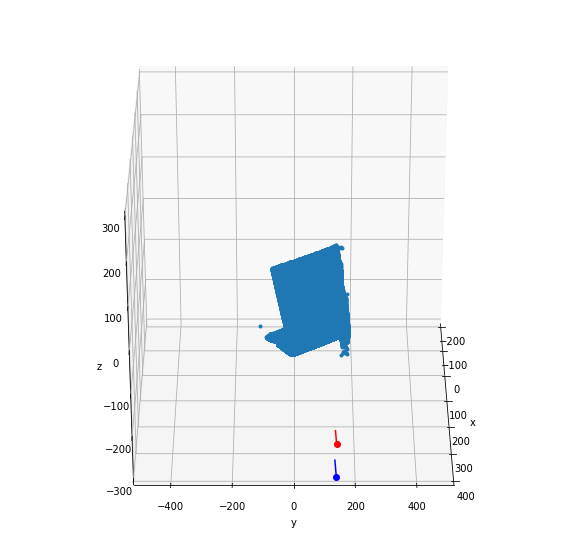

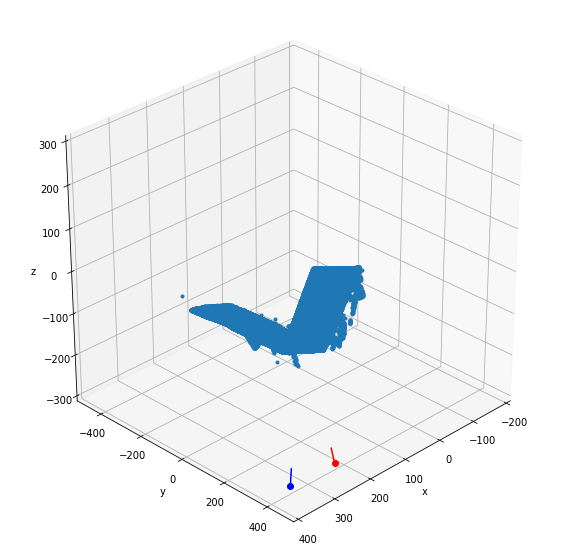

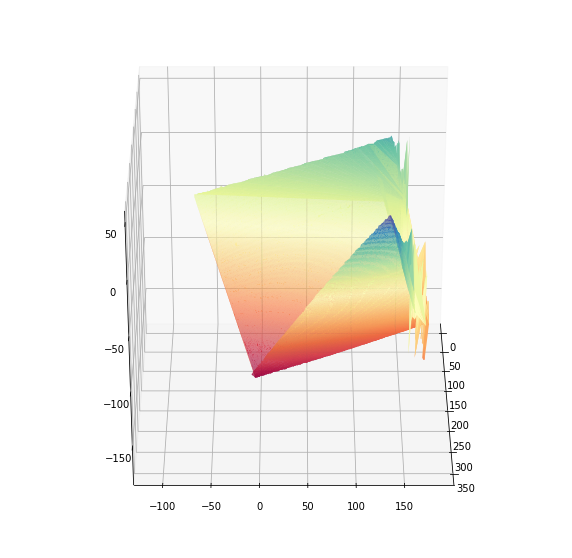

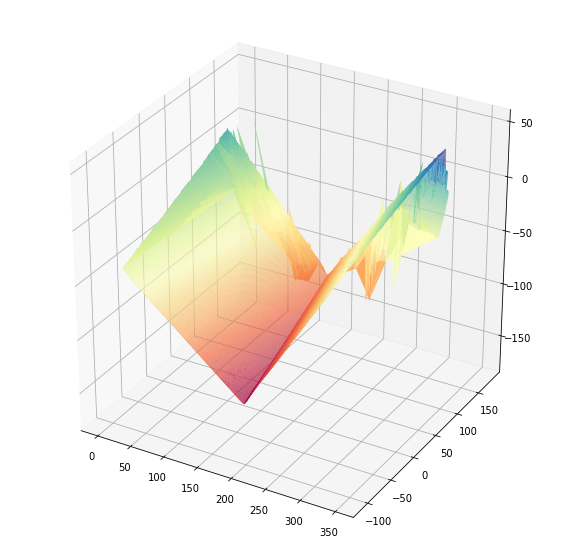

In [32]:
lookL = np.hstack((camL.t, camL.t + camL.R @ np.array([[0, 0, 40]]).T))
lookR = np.hstack((camR.t, camR.t + camR.R @ np.array([[0, 0, 40]]).T))
for i in range(2):
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.view_init(azim=(i * 45))
    ax.plot(xyz_trimmed[0, :], xyz_trimmed[1, :], xyz_trimmed[2, :], '.')
    ax.plot(camR.t[0], camR.t[1], camR.t[2], 'ro')
    ax.plot(camL.t[0], camL.t[1], camL.t[2], 'bo')
    ax.plot(lookL[0, :], lookL[1, :], lookL[2, :], 'b')
    ax.plot(lookR[0, :], lookR[1, :], lookR[2, :], 'r')
    visutils.set_axes_equal_3d(ax)
    visutils.label_axes(ax)
    ax.set_zlim(-300, 300)
    ax.set_ylim(-500, 500)
    ax.set_xlim(-200, 400)
    plt.show()
    

fig = plt.figure()
x, y, z = xyz_trimmed
ax = fig.gca(projection="3d")
ax.plot_trisurf(x, y, z, triangles=simp, cmap=plt.cm.Spectral)
ax.view_init(azim=0)
plt.show()
    
fig = plt.figure()
x, y, z = xyz_trimmed
ax = fig.gca(projection="3d")
ax.plot_trisurf(x, y, z, triangles=simp, cmap=plt.cm.Spectral)
ax.view_init(azim=300)
plt.show()



For each point of the box I pruned the desired 3D model. I searched for the maximums and minimums after splicing the object in half. To find the V bottom I tried to use the value of each to remove any excess points relatively close to the desired shape. For the threshold I iterated through each triangle to find if any edge is greater than the threshold. If it is, then it is removed. To remove the large triangles I was able to use the box to remove excesses. I failed adding points to 'smoothen' the many triangles. It just added more points to make the box look the same. To improve the mesh, I was wondering about a nice gaussian blur for the mask and a further refinement of the average of the nearest neighbors for outliers.


Besides the outliers outside the box, there were some points on the box itself that made it look like a 'pimple'. This could be a very difficult task to remove since I wasn't sure how to remove it without valid points. I figured iterating through each slice to smooth the surface and taking the average of all of its neighbors would be ideal on larger projects. Instead I figured to remove the point since it was a simple fix, but for larger more tedious projects, I'd definitely look into it. I figured the best placement of the cameras would be somewhere to minimize the hull and still able to see the sides of the box for alignment. I included an image describing the location of each cameras.

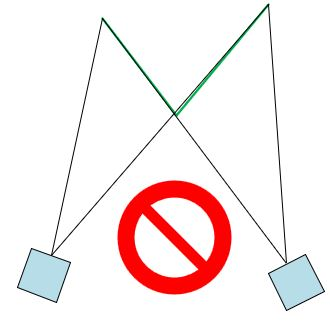 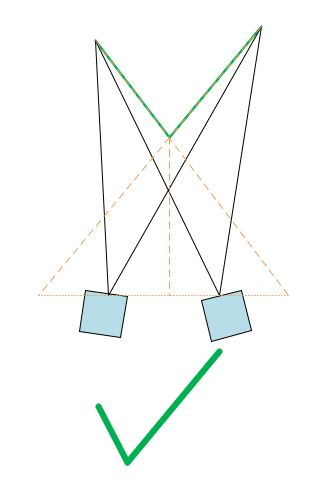